# V(D)J与基因表达整合分析 - 第一部分

## 非小细胞肺癌样本中淋巴细胞的克隆性和多样性分析

### 概述
本notebook模拟了**10x Genomics Loupe Browser V(D)J教程第一部分**中描述的功能。我们创建模拟数据来演示V(D)J与基因表达整合分析的关键分析流程。

### 实现的功能

#### 📊 **数据模拟**
- 生成具有重叠、不规则形状聚类的真实模拟单细胞RNA-seq数据
- 创建模拟的细胞类型注释：CD8+细胞毒性T细胞、CD4+辅助T细胞、其他T细胞、B细胞、上皮细胞
- 生成相应的V(D)J克隆型数据，包含真实的TCR基因信息

#### 🔬 **细胞类型可视化** 
- 在UMAP嵌入上可视化细胞类型（相当于Loupe Browser的类别模式）
- 显示不同免疫细胞和上皮细胞群体的分布

#### 🧬 **V(D)J克隆型整合**
- 导入并合并V(D)J克隆型信息与基因表达数据
- 在UMAP上用蓝色高亮显示具有V(D)J信息的细胞（T/B细胞）
- 将克隆型与细胞表型关联

#### 🎯 **克隆型分析**
- 识别最丰富的T细胞克隆型
- 可视化克隆型在不同细胞类型中的分布
- 证明顶级克隆型通常出现在CD8+细胞毒性T细胞中

#### 🏷️ **MAIT细胞识别**
- 基于V(D)J基因使用模式筛选克隆型（TRAV1-2 + TRAJ33）
- 创建包含MAIT细胞的新细胞类型注释
- 演示基于克隆型特征的细胞分组

---

### 技术方法
- **数据生成**：使用带随机变换的`make_blobs`创建真实的重叠聚类
- **V(D)J模拟**：生成具有生物学相关基因名称的模拟TCR数据
- **可视化**：采用`scanpy`进行标准单细胞分析和UMAP可视化
- **整合**：使用共享细胞条形码合并V(D)J和基因表达数据

本模拟提供了Loupe Browser V(D)J教程中关键概念和工作流程的实践体验，无需实际的商业软件或数据集。


## 1. 环境设置与数据模拟函数

首先，我们导入必要的库并定义优化的模拟数据生成函数。该函数创建具有重叠、不规则形状聚类的真实单细胞数据，更好地模拟真实的生物学数据。


In [1]:
import scanpy as sc
import pandas as pd
import numpy as np
from sklearn.datasets import make_blobs
import warnings

warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=UserWarning)

# --- 优化的模拟数据生成函数 ---
def generate_mock_data(part='I'):
    """
    生成具有重叠、不规则聚类的真实模拟单细胞数据。
    
    参数:
    -----------
    part : str
        'I' 表示肺癌数据集，'II' 表示BEAM数据集
    
    返回:
    --------
    adata : AnnData
        包含基因表达和元数据的注释数据对象
    vdj_df : DataFrame
        V(D)J克隆型信息
    """
    # 定义基本参数
    n_obs = 3000      # 细胞数量
    n_vars = 500      # 基因数量
    n_clusters = 5    # 细胞聚类数量
    n_latent_dims = 15 # 真实数据结构的潜在维度

    # --- 核心改进1：生成重叠的基础聚类 ---
    # 更大的cluster_std使聚类更分散
    centers = np.random.rand(n_clusters, n_latent_dims) * 10 
    X_latent, y_true = make_blobs(
        n_samples=n_obs,
        n_features=n_latent_dims,
        centers=centers,
        cluster_std=2.0,  # 增加标准差以获得更真实的重叠
        random_state=42
    )

    # --- 核心改进2：应用随机拉伸以打破圆形形状 ---
    X_latent_transformed = np.zeros_like(X_latent)
    for i in range(n_clusters):
        # 找到属于当前聚类的细胞
        cluster_indices = (y_true == i)
        cluster_points = X_latent[cluster_indices]
        
        # 将数据居中以保持聚类中心
        mean_center = cluster_points.mean(axis=0)
        cluster_points_centered = cluster_points - mean_center
        
        # 创建随机拉伸/压缩变换
        # 每个维度都乘以0.5到2.5之间的因子
        scaling_factors = np.random.uniform(0.5, 2.5, size=n_latent_dims)
        transformed_points = cluster_points_centered * scaling_factors
        
        # 将变换后的数据移回原始中心
        X_latent_transformed[cluster_indices] = transformed_points + mean_center
    
    # 使用变换后的潜在空间生成基因表达矩阵
    X_latent = X_latent_transformed
    projection_matrix = np.random.normal(size=(n_latent_dims, n_vars))
    X = X_latent @ projection_matrix
    X += np.random.normal(scale=0.8, size=X.shape)
    X = np.abs(X)  # 确保表达值为非负

    # 创建AnnData对象
    barcodes = [f'BARCODE_{i}' for i in range(n_obs)]
    adata = sc.AnnData(
        X, 
        obs=pd.DataFrame(index=barcodes), 
        var=pd.DataFrame(index=[f'Gene_{j}' for j in range(n_vars)])
    )
    adata.obs['leiden_original'] = pd.Categorical(y_true)

    # 为部分细胞生成V(D)J数据（70%的细胞有V(D)J信息）
    vdj_barcodes = np.random.choice(barcodes, size=int(n_obs * 0.7), replace=False)
    vdj_data = []

    if part == 'I':
        # 第一部分：肺癌细胞类型注释
        adata.obs['cell_type'] = 'Other'
        adata.obs.loc[adata.obs['leiden_original'] == 0, 'cell_type'] = 'CD8+ Cytotoxic T'
        adata.obs.loc[adata.obs['leiden_original'] == 1, 'cell_type'] = 'CD4+ Helper T'
        adata.obs.loc[adata.obs['leiden_original'] == 2, 'cell_type'] = 'Other T cells'
        adata.obs.loc[adata.obs['leiden_original'] == 3, 'cell_type'] = 'B cells'
        adata.obs.loc[adata.obs['leiden_original'] == 4, 'cell_type'] = 'Epithelial cells'
        adata.obs['cell_type'] = pd.Categorical(adata.obs['cell_type'])
        
        # 生成真实的T细胞克隆型
        clonotypes = [f'clonotype_{i}' for i in range(50)]
        cd8_cells = adata.obs_names[adata.obs['cell_type'] == 'CD8+ Cytotoxic T']
        cd8_vdj_cells = np.intersect1d(vdj_barcodes, cd8_cells)
        
        for i, bc in enumerate(vdj_barcodes):
            ct = np.random.choice(clonotypes)
            # 使clonotype_1在CD8+ T细胞中占主导地位
            if bc in cd8_vdj_cells and i < len(cd8_vdj_cells) / 2: 
                ct = 'clonotype_1'
            
            # 生成真实的V和J基因名称
            # 特殊情况：clonotype_5代表具有特定基因的MAIT细胞
            v_gene = 'TRAV1-2' if ct == 'clonotype_5' else f'TRAV{np.random.randint(2,10)}'
            j_gene = 'TRAJ33' if ct == 'clonotype_5' else f'TRAJ{np.random.randint(1,20)}'
            
            vdj_data.append({
                'barcode': bc, 
                'clonotype_id': ct, 
                'v_gene': v_gene, 
                'j_gene': j_gene
            })

    vdj_df = pd.DataFrame(vdj_data)
    
    # 标准的scanpy预处理流程
    sc.pp.normalize_total(adata, target_sum=1e4)
    sc.pp.log1p(adata)
    sc.pp.highly_variable_genes(adata, n_top_genes=200)
    sc.pp.pca(adata)
    sc.pp.neighbors(adata)
    sc.tl.umap(adata)
    sc.tl.leiden(adata, resolution=0.5, key_added='leiden')

    return adata, vdj_df

print("优化的模拟数据生成函数定义成功。")


优化的模拟数据生成函数定义成功。


## 2. 数据生成与初始可视化

现在我们生成模拟的肺癌数据集并可视化细胞类型。这相当于在Loupe Browser中加载`.cloupe`文件并在类别模式下查看手动注释的细胞类型。


第一部分：模拟肺癌样本
细胞总数：3000
细胞类型分布：
cell_type
B cells             600
CD4+ Helper T       600
CD8+ Cytotoxic T    600
Epithelial cells    600
Other T cells       600
Name: count, dtype: int64


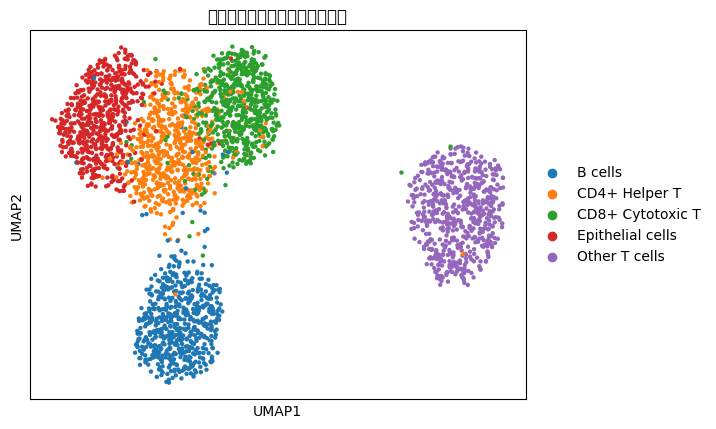

In [2]:
# --- 生成和加载数据 ---
adata_p1, vdj_df_p1 = generate_mock_data(part='I')

# --- 可视化细胞类型（相当于Loupe Browser的类别模式）---
print("第一部分：模拟肺癌样本")
print(f"细胞总数：{adata_p1.n_obs}")
print(f"细胞类型分布：")
print(adata_p1.obs['cell_type'].value_counts())

sc.pl.umap(
    adata_p1, 
    color='cell_type', 
    title='按细胞类型分类的模拟肺癌样本'
)


## 3. 导入并可视化V(D)J克隆型

这一步模拟将`.vloupe`文件导入Loupe Browser。我们将V(D)J克隆型信息与基因表达数据合并，并在UMAP上用蓝色高亮显示具有V(D)J信息的细胞（T和B细胞）。


具有V(D)J信息的细胞：2100 / 3000
独特克隆型总数：50


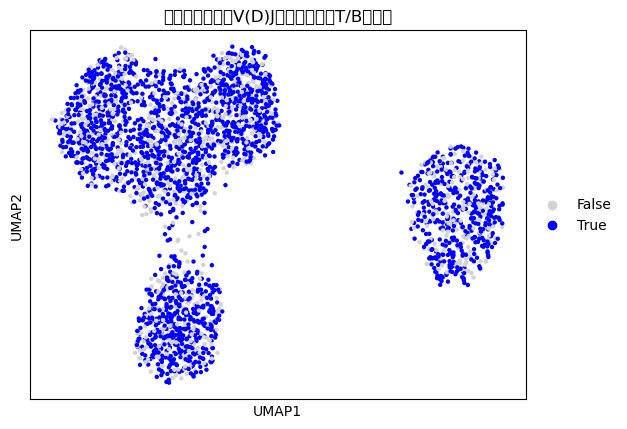

In [3]:
# 目的：关联V(D)J信息并高亮T/B细胞
# 教程对应：「导入克隆型」部分

# 使用条形码匹配将VDJ信息合并到AnnData对象中
adata_p1.obs = adata_p1.obs.reset_index().merge(
    vdj_df_p1, left_on='index', right_on='barcode', how='left'
).set_index('index')

# 创建新列标记哪些细胞有VDJ信息
adata_p1.obs['has_vdj'] = adata_p1.obs['clonotype_id'].notna()

print(f"具有V(D)J信息的细胞：{adata_p1.obs['has_vdj'].sum()} / {adata_p1.n_obs}")
print(f"独特克隆型总数：{adata_p1.obs['clonotype_id'].nunique()}")

# 可视化所有具有VDJ信息的细胞
# 注意：由于分类转换，使用字符串键作为调色板
sc.pl.umap(
    adata_p1,
    color='has_vdj',
    title='第一部分：具有V(D)J信息的细胞（T/B细胞）',
    palette={'True': 'blue', 'False': 'lightgray'}
)


## 4. 分析顶级克隆型并与表型关联

这展示了V(D)J与基因表达整合分析的关键优势：将克隆型与细胞表型关联。我们识别最丰富的克隆型并可视化其在不同细胞类型中的分布。


最丰富的克隆型：clonotype_1（86个细胞）

前5个克隆型：
clonotype_id
clonotype_1     86
clonotype_16    54
clonotype_9     52
clonotype_29    52
clonotype_40    51
Name: count, dtype: int64

顶级克隆型细胞类型分布：
cell_type
CD8+ Cytotoxic T    59
Other T cells        8
Epithelial cells     8
B cells              6
CD4+ Helper T        5
Name: count, dtype: int64


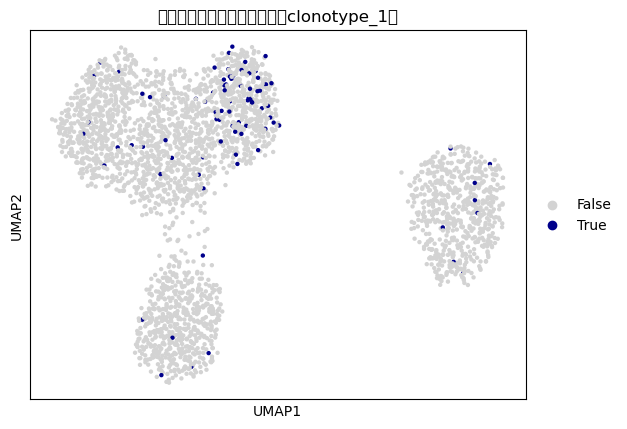

In [4]:
# 找到最丰富的克隆型
clonotype_counts = adata_p1.obs['clonotype_id'].value_counts()
top_clonotype = clonotype_counts.index[0]
top_clonotype_count = clonotype_counts.iloc[0]

print(f"最丰富的克隆型：{top_clonotype}（{top_clonotype_count}个细胞）")
print("\n前5个克隆型：")
print(clonotype_counts.head())

# 创建新列标记属于顶级克隆型的细胞
adata_p1.obs['is_top_clonotype'] = (adata_p1.obs['clonotype_id'] == top_clonotype)

# 分析顶级克隆型属于哪些细胞类型
top_clonotype_cells = adata_p1.obs[adata_p1.obs['is_top_clonotype']]
print(f"\n顶级克隆型细胞类型分布：")
print(top_clonotype_cells['cell_type'].value_counts())

# 在UMAP上高亮显示该克隆型的位置
sc.pl.umap(
    adata_p1,
    color='is_top_clonotype',
    title=f'第一部分：顶级克隆型位置（{top_clonotype}）',
    palette={'True': 'darkblue', 'False': 'lightgray'},
    groups=['True']  # 仅高亮属于该克隆型的细胞
)


## 5. 基于克隆型识别和分组MAIT细胞

本部分演示如何基于V(D)J特征创建新的细胞群组。MAIT细胞（粘膜相关不变T细胞）具有半不变的TCR，具有特定的V和J基因使用模式。我们筛选具有TRAV1-2和TRAJ33基因的细胞并创建新的细胞类型类别。


识别出43个模拟MAIT细胞。

MAIT细胞在原始细胞类型中的分布：
cell_type
Epithelial cells    11
CD4+ Helper T       10
B cells              9
Other T cells        7
CD8+ Cytotoxic T     6
Name: count, dtype: int64

更新的细胞类型分布：
cell_type_with_mait
CD8+ Cytotoxic T    594
Other T cells       593
B cells             591
CD4+ Helper T       590
Epithelial cells    589
MAIT Cells           43
Name: count, dtype: int64


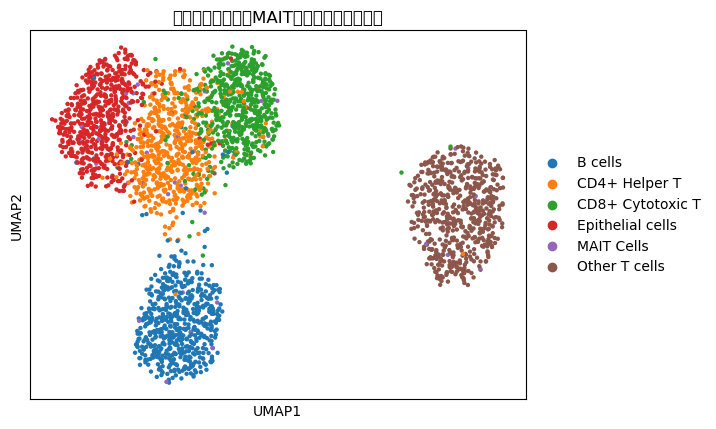

In [5]:
# 基于V/J基因使用筛选模拟MAIT细胞
# MAIT细胞特征性地使用TRAV1-2 V基因和TRAJ33 J基因
is_mait = (adata_p1.obs['v_gene'] == 'TRAV1-2') & (adata_p1.obs['j_gene'] == 'TRAJ33')
mait_count = is_mait.sum()

print(f"识别出{mait_count}个模拟MAIT细胞。")

if mait_count > 0:
    print("\nMAIT细胞在原始细胞类型中的分布：")
    mait_cells = adata_p1.obs[is_mait]
    print(mait_cells['cell_type'].value_counts())

# 创建包含MAIT细胞的新细胞类型注释列
adata_p1.obs['cell_type_with_mait'] = adata_p1.obs['cell_type'].astype(str)

# 将筛选出的细胞分配到新的'MAIT Cells'类别
adata_p1.obs.loc[is_mait, 'cell_type_with_mait'] = 'MAIT Cells'
adata_p1.obs['cell_type_with_mait'] = pd.Categorical(adata_p1.obs['cell_type_with_mait'])

print(f"\n更新的细胞类型分布：")
print(adata_p1.obs['cell_type_with_mait'].value_counts())

# 可视化包含新MAIT细胞群组的细胞类型
sc.pl.umap(
    adata_p1, 
    color='cell_type_with_mait', 
    title='第一部分：包含新MAIT细胞群组的细胞类型'
)


## 总结

本notebook成功演示了Loupe Browser V(D)教程第一部分的关键工作流程：

✅ **完成的分析：**
1. **数据加载**：模拟肺癌基因表达数据集并进行细胞类型注释
2. **V(D)J整合**：导入并合并克隆型信息与基因表达数据
3. **克隆型分析**：识别最丰富的克隆型及其表型关联
4. **细胞分组**：基于V(D)J基因使用模式创建新的MAIT细胞类别

✅ **主要发现：**
- 最丰富的克隆型主要出现在CD8+细胞毒性T细胞中
- 约70%的细胞具有V(D)J信息（对T/B细胞群体来说是现实的）
- 可基于特征性TCR基因使用模式识别和分组MAIT细胞

本模拟提供了V(D)J与基因表达整合分析的实践体验，无需商业软件或专有数据集。这里演示的工作流程直接对应于10x Genomics Loupe Browser在癌症样本中研究淋巴细胞克隆性和多样性的分析能力。
